In [4]:
!pip install datasets


In [5]:
pip install datasets


In [6]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import pandas as pd
import re
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from nltk.corpus import stopwords
import nltk
import numpy as np

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Download NLTK stopwords
nltk.download('stopwords')
marathi_stopwords = set(stopwords.words('english'))

# Load the dataset
file_path = 'english.csv'  # Update the file path if necessary
poetry_data = pd.read_csv('english.csv')

# Preprocessing Function for Text Normalization
def preprocess_text(text):
    # Lowercasing
    text = text.lower()

    # Remove special characters and punctuation (keeping alphabet and spaces)
    text = re.sub(r'[^a-zA-Z ]', '', text)  # Keep only English alphabet characters
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply text preprocessing to the 'Sentence' column
poetry_data['Sentence'] = poetry_data['Sentence'].apply(preprocess_text)

# Remove stopwords from the sentences
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in marathi_stopwords])

poetry_data['Sentence'] = poetry_data['Sentence'].apply(remove_stopwords)

# Optional: Remove short and long sentences (based on word count)
poetry_data = poetry_data[poetry_data['Sentence'].apply(lambda x: 3 < len(x.split()) < 50)]

# Handling class imbalance for sentiment (Oversampling minority classes)
sentiment_counts = poetry_data['Sentiment'].value_counts()
min_class = sentiment_counts.idxmin()

# Resampling the minority class
minority_class = poetry_data[poetry_data['Sentiment'] == min_class]
majority_class = poetry_data[poetry_data['Sentiment'] != min_class]

# Upsample the minority class
minority_upsampled = resample(minority_class,
                              replace=True,    # Sample with replacement
                              n_samples=len(majority_class), # Match majority class
                              random_state=42)

# Combine the upsampled minority class with the majority class
poetry_data_balanced = pd.concat([majority_class, minority_upsampled])

# Ensure your dataset has the 'Sentence', 'Sentiment', and 'Emotion' columns
hf_dataset_sentiment = Dataset.from_pandas(poetry_data_balanced[['Sentence', 'Sentiment']])
hf_dataset_emotion = Dataset.from_pandas(poetry_data_balanced[['Sentence', 'Emotion']])

# Map sentiment labels (adjust based on your dataset)
sentiment_label_mapping = {
    'Negative': 0,
    'Neutral': 1,
    'Positive': 2
}

# Updated emotion mapping based on unique values in your dataset
emotion_label_mapping = {
    'Joy': 0,
    'Peace': 1,
    'Love': 2,
    'Anger': 3,
    'Hope': 4,
    'Calm': 5,
    'Grief': 6,
    'Acceptance': 7,
    'Sadness': 8,
}

# Map the labels to numerical values
hf_dataset_sentiment = hf_dataset_sentiment.map(lambda x: {'labels': sentiment_label_mapping[x['Sentiment']]})
hf_dataset_emotion = hf_dataset_emotion.map(lambda x: {'labels': emotion_label_mapping[x['Emotion']]})

# Tokenizer
sentiment_tokenizer = RobertaTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
emotion_tokenizer = AutoTokenizer.from_pretrained("bhadresh-savani/distilbert-base-uncased-emotion")

# Tokenize the dataset with reduced sequence length
def tokenize_sentiment(example):
    return sentiment_tokenizer(example['Sentence'], padding="max_length", truncation=True, max_length=128)

def tokenize_emotion(example):
    return emotion_tokenizer(example['Sentence'], padding="max_length", truncation=True, max_length=128)

hf_dataset_sentiment = hf_dataset_sentiment.map(tokenize_sentiment, batched=True)
hf_dataset_emotion = hf_dataset_emotion.map(tokenize_emotion, batched=True)

# Load pre-trained models and send them to the GPU if available
sentiment_model = RobertaForSequenceClassification.from_pretrained(
    "cardiffnlp/twitter-roberta-base-sentiment",
    num_labels=3
).to(device)

emotion_model = AutoModelForSequenceClassification.from_pretrained(
    "bhadresh-savani/distilbert-base-uncased-emotion",
    num_labels=len(emotion_label_mapping),
    ignore_mismatched_sizes=True
).to(device)

# Freeze lower layers of the models for faster training
for param in sentiment_model.roberta.embeddings.parameters():
    param.requires_grad = False  # Freeze embedding layer

for param in sentiment_model.roberta.encoder.layer[:6].parameters():
    param.requires_grad = False  # Freeze the first 6 layers of the encoder

# Compute metrics for evaluation using scikit-learn
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Training arguments for sentiment analysis with optimizations
training_args_sentiment = TrainingArguments(
    output_dir="./sentiment_results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,  # Reduced number of epochs
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    gradient_accumulation_steps=4,  # Gradient accumulation
    fp16=True,  # Mixed precision training
    lr_scheduler_type="cosine"  # Cosine decay learning rate scheduler
)

# Training arguments for emotion analysis with optimizations
training_args_emotion = TrainingArguments(
    output_dir="./emotion_results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,  # Reduced number of epochs
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    gradient_accumulation_steps=4,  # Gradient accumulation
    fp16=True,  # Mixed precision training
    lr_scheduler_type="cosine"  # Cosine decay learning rate scheduler
)

# Trainer for sentiment analysis
trainer_sentiment = Trainer(
    model=sentiment_model,
    args=training_args_sentiment,
    train_dataset=hf_dataset_sentiment,
    eval_dataset=hf_dataset_sentiment,
    tokenizer=sentiment_tokenizer,
    compute_metrics=compute_metrics
)

# Trainer for emotion analysis (continued)
trainer_emotion = Trainer(
    model=emotion_model,
    args=training_args_emotion,
    train_dataset=hf_dataset_emotion,
    eval_dataset=hf_dataset_emotion,
    tokenizer=emotion_tokenizer,
    compute_metrics=compute_metrics
)

# Fine-tune the models
trainer_sentiment.train()
trainer_emotion.train()

# Save the fine-tuned models
sentiment_model.save_pretrained('./fine_tuned_sentiment_model')
emotion_model.save_pretrained('./fine_tuned_emotion_model')

# Evaluate the models on the dataset
sentiment_results = trainer_sentiment.evaluate()
emotion_results = trainer_emotion.evaluate()

print("Sentiment Analysis Results:", sentiment_results)
print("Emotion Analysis Results:", emotion_results)


Using device: cuda


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Map:   0%|          | 0/244124 [00:00<?, ? examples/s]

Map:   0%|          | 0/244124 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/244124 [00:00<?, ? examples/s]

Map:   0%|          | 0/244124 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at bhadresh-savani/distilbert-base-uncased-emotion and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([6]) in the checkpoint and torch.Size([9]) in the model instantiated
- classifier.weight: found shape torch.Size([6, 768]) in the checkpoint and torch.Size([9, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnin

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,0.056000,0.032341,0.988047,0.988019,0.987808,0.987913


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,0.060300,0.047629,0.983172,0.980876,0.979797,0.980241


Sentiment Analysis Results: {'eval_loss': 0.03234122321009636, 'eval_accuracy': 0.9880470580524652, 'eval_precision': 0.9880190086780823, 'eval_recall': 0.9878076412412554, 'eval_f1': 0.9879131802715092, 'eval_runtime': 577.467, 'eval_samples_per_second': 422.75, 'eval_steps_per_second': 26.422, 'epoch': 0.9998689212216542}
Emotion Analysis Results: {'eval_loss': 0.04762851819396019, 'eval_accuracy': 0.9831724861136144, 'eval_precision': 0.9808755532296792, 'eval_recall': 0.9797973537059512, 'eval_f1': 0.9802408784728124, 'eval_runtime': 314.8804, 'eval_samples_per_second': 775.291, 'eval_steps_per_second': 48.456, 'epoch': 0.9998689212216542}


In [7]:
# Get predictions for sentiment
sentiment_predictions = trainer_sentiment.predict(hf_dataset_sentiment)

# Get predictions for emotion
emotion_predictions = trainer_emotion.predict(hf_dataset_emotion)

# Save these variables to use them later for plotting ROC and AUC


In [8]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# Load fine-tuned sentiment model
sentiment_model = AutoModelForSequenceClassification.from_pretrained('./fine_tuned_sentiment_model')
sentiment_tokenizer = RobertaTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

# Load fine-tuned emotion model
emotion_model = AutoModelForSequenceClassification.from_pretrained('./fine_tuned_emotion_model')
emotion_tokenizer = AutoTokenizer.from_pretrained("bhadresh-savani/distilbert-base-uncased-emotion")

# Move models to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sentiment_model.to(device)
emotion_model.to(device)

# Make predictions (example sentences)
example_sentences = ["This is a great day.", "I feel sad and lost."]

# Tokenize sentences for sentiment model
sentiment_inputs = sentiment_tokenizer(example_sentences, padding=True, truncation=True, return_tensors='pt').to(device)

# Tokenize sentences for emotion model
emotion_inputs = emotion_tokenizer(example_sentences, padding=True, truncation=True, return_tensors='pt').to(device)

# Predict sentiment
with torch.no_grad():
    sentiment_outputs = sentiment_model(**sentiment_inputs)
    sentiment_predictions = sentiment_outputs.logits.argmax(dim=-1).cpu().numpy()

# Predict emotion
with torch.no_grad():
    emotion_outputs = emotion_model(**emotion_inputs)
    emotion_predictions = emotion_outputs.logits.argmax(dim=-1).cpu().numpy()

print("Sentiment Predictions:", sentiment_predictions)
print("Emotion Predictions:", emotion_predictions)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Sentiment Predictions: [2 0]
Emotion Predictions: [0 8]


In [9]:
pip install scikit-learn


In [10]:
torch.cuda.empty_cache()


In [11]:
device = torch.device('cpu')
sentiment_model.to(device)
emotion_model.to(device)

# Proceed with CPU-based inference


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

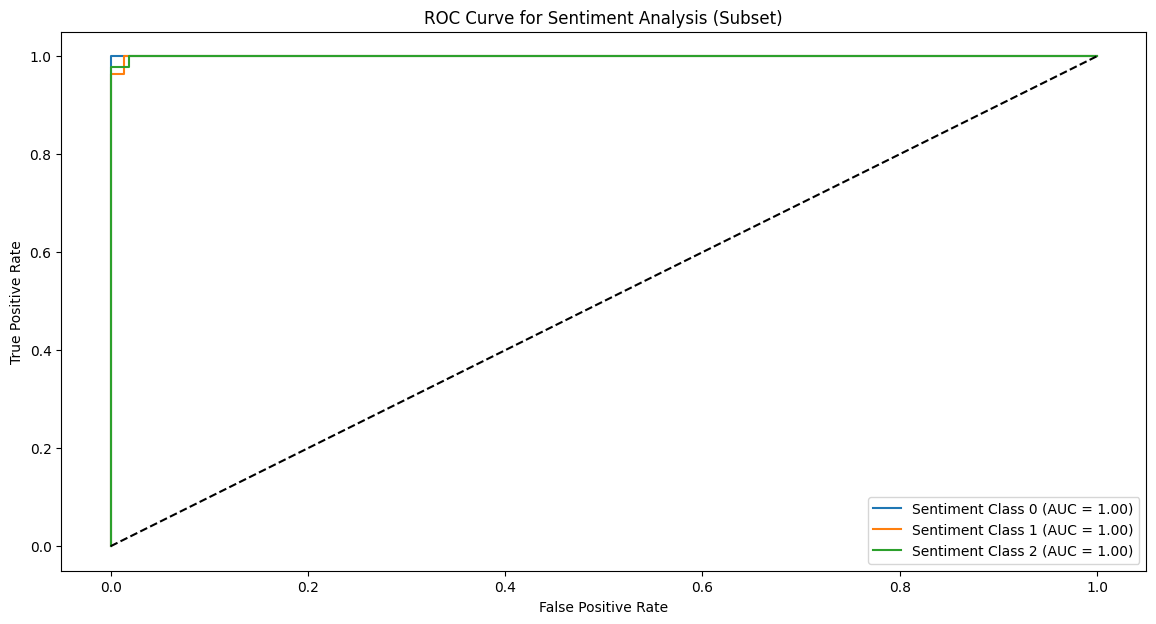

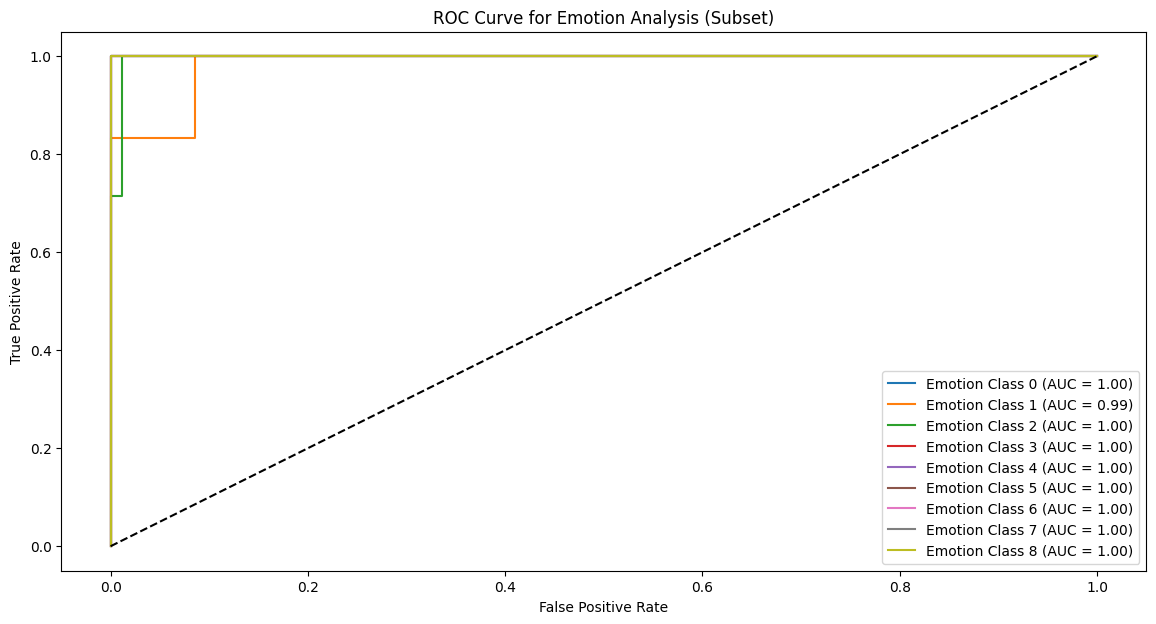

In [12]:
import torch
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader, TensorDataset

# Load fine-tuned models
sentiment_model = AutoModelForSequenceClassification.from_pretrained('./fine_tuned_sentiment_model')
emotion_model = AutoModelForSequenceClassification.from_pretrained('./fine_tuned_emotion_model')

# Load tokenizers
sentiment_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
emotion_tokenizer = AutoTokenizer.from_pretrained("bhadresh-savani/distilbert-base-uncased-emotion")

# Move models to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sentiment_model.to(device)
emotion_model.to(device)

# Select a subset of the dataset (e.g., 100 random samples)
subset_size = 100
subset_data = poetry_data_balanced.sample(n=subset_size, random_state=42)

# True sentiment and emotion labels
true_sentiments = subset_data['Sentiment'].tolist()
true_emotions = subset_data['Emotion'].tolist()

# Convert true labels to numerical format (based on the mappings)
sentiment_label_mapping = {
    'Negative': 0,
    'Neutral': 1,
    'Positive': 2
}

emotion_label_mapping = {
    'Joy': 0,
    'Peace': 1,
    'Love': 2,
    'Anger': 3,
    'Hope': 4,
    'Calm': 5,
    'Grief': 6,
    'Acceptance': 7,
    'Sadness': 8,
}

true_sentiments_numerical = [sentiment_label_mapping[s] for s in true_sentiments]
true_emotions_numerical = [emotion_label_mapping[e] for e in true_emotions]

# Tokenize the sentences
sentiment_inputs = sentiment_tokenizer(subset_data['Sentence'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)
emotion_inputs = emotion_tokenizer(subset_data['Sentence'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)

# Create TensorDatasets for sentiment and emotion
sentiment_dataset = TensorDataset(sentiment_inputs['input_ids'], sentiment_inputs['attention_mask'], torch.tensor(true_sentiments_numerical))
emotion_dataset = TensorDataset(emotion_inputs['input_ids'], emotion_inputs['attention_mask'], torch.tensor(true_emotions_numerical))

# Create DataLoaders with smaller batch sizes to reduce memory usage
sentiment_loader = DataLoader(sentiment_dataset, batch_size=16)
emotion_loader = DataLoader(emotion_dataset, batch_size=16)

# Collect predicted probabilities for sentiment
sentiment_probabilities = []
with torch.no_grad():
    for batch in sentiment_loader:
        input_ids, attention_mask, _ = [b.to(device) for b in batch]
        outputs = sentiment_model(input_ids=input_ids, attention_mask=attention_mask)
        sentiment_probabilities.append(torch.softmax(outputs.logits, dim=1).cpu().numpy())

sentiment_probabilities = np.concatenate(sentiment_probabilities)

# Collect predicted probabilities for emotion
emotion_probabilities = []
with torch.no_grad():
    for batch in emotion_loader:
        input_ids, attention_mask, _ = [b.to(device) for b in batch]
        outputs = emotion_model(input_ids=input_ids, attention_mask=attention_mask)
        emotion_probabilities.append(torch.softmax(outputs.logits, dim=1).cpu().numpy())

emotion_probabilities = np.concatenate(emotion_probabilities)

# For ROC/AUC, we need to binarize the labels in a one-vs-rest approach
# Binarize the sentiment labels (assuming 3 classes: Negative, Neutral, Positive)
true_labels_sentiment_binarized = label_binarize(true_sentiments_numerical, classes=[0, 1, 2])

# Binarize the emotion labels (based on the number of emotion classes)
true_labels_emotion_binarized = label_binarize(true_emotions_numerical, classes=[i for i in range(len(emotion_label_mapping))])

# Plot ROC curve for Sentiment
fpr_sentiment = dict()
tpr_sentiment = dict()
roc_auc_sentiment = dict()

for i in range(3):  # Assuming 3 sentiment classes
    fpr_sentiment[i], tpr_sentiment[i], _ = roc_curve(true_labels_sentiment_binarized[:, i], sentiment_probabilities[:, i])
    roc_auc_sentiment[i] = auc(fpr_sentiment[i], tpr_sentiment[i])

plt.figure(figsize=(14, 7))
for i in range(3):
    plt.plot(fpr_sentiment[i], tpr_sentiment[i], label=f'Sentiment Class {i} (AUC = {roc_auc_sentiment[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Sentiment Analysis (Subset)')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for Emotion
fpr_emotion = dict()
tpr_emotion = dict()
roc_auc_emotion = dict()

for i in range(len(emotion_label_mapping)):  # Based on the number of emotion classes
    fpr_emotion[i], tpr_emotion[i], _ = roc_curve(true_labels_emotion_binarized[:, i], emotion_probabilities[:, i])
    roc_auc_emotion[i] = auc(fpr_emotion[i], tpr_emotion[i])

plt.figure(figsize=(14, 7))
for i in range(len(emotion_label_mapping)):
    plt.plot(fpr_emotion[i], tpr_emotion[i], label=f'Emotion Class {i} (AUC = {roc_auc_emotion[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Emotion Analysis (Subset)')
plt.legend(loc="lower right")
plt.show()


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


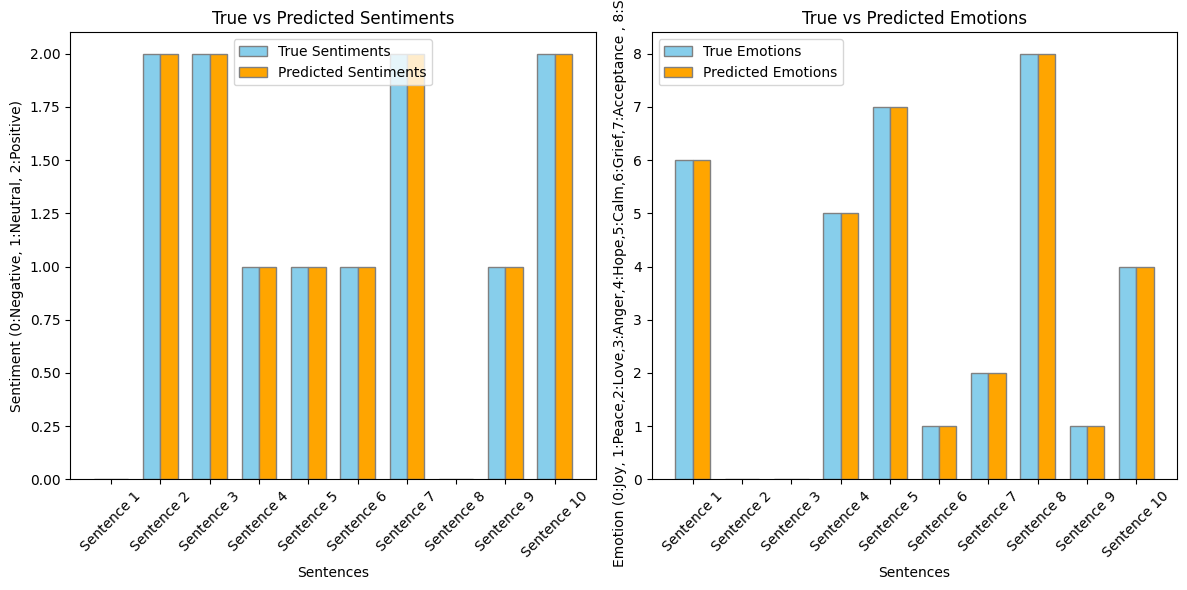

In [13]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from datasets import Dataset

# Load fine-tuned models
sentiment_model = AutoModelForSequenceClassification.from_pretrained('./fine_tuned_sentiment_model')
emotion_model = AutoModelForSequenceClassification.from_pretrained('./fine_tuned_emotion_model')

# Load tokenizers
sentiment_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
emotion_tokenizer = AutoTokenizer.from_pretrained("bhadresh-savani/distilbert-base-uncased-emotion")

# Move models to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sentiment_model.to(device)
emotion_model.to(device)

# Randomly select 10 sentences from your dataset
# Assuming `poetry_data_balanced` is a pandas DataFrame containing your dataset
random_sentences = poetry_data_balanced.sample(n=10, random_state=42)

# True sentiment and emotion labels
true_sentiments = random_sentences['Sentiment'].tolist()
true_emotions = random_sentences['Emotion'].tolist()

# Convert true labels to numerical format (based on the mappings)
sentiment_label_mapping = {
    'Negative': 0,
    'Neutral': 1,
    'Positive': 2
}

emotion_label_mapping = {
    'Joy': 0,
    'Peace': 1,
    'Love': 2,
    'Anger': 3,
    'Hope': 4,
    'Calm': 5,
    'Grief': 6,
    'Acceptance': 7,
    'Sadness': 8,
}

true_sentiments_numerical = [sentiment_label_mapping[s] for s in true_sentiments]
true_emotions_numerical = [emotion_label_mapping[e] for e in true_emotions]

# Tokenize the sentences
sentiment_inputs = sentiment_tokenizer(random_sentences['Sentence'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)
emotion_inputs = emotion_tokenizer(random_sentences['Sentence'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)

# Get predicted values for sentiment
with torch.no_grad():
    sentiment_outputs = sentiment_model(**sentiment_inputs)
    sentiment_predictions = sentiment_outputs.logits.argmax(dim=-1).cpu().numpy()

# Get predicted values for emotion
with torch.no_grad():
    emotion_outputs = emotion_model(**emotion_inputs)
    emotion_predictions = emotion_outputs.logits.argmax(dim=-1).cpu().numpy()

# Now create a double bar graph comparing true vs predicted values for both sentiment and emotion

# Plot double bar graph for sentiment
categories = [f"Sentence {i+1}" for i in range(len(random_sentences))]
bar_width = 0.35
r1 = np.arange(len(categories))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))

# Sentiment plot
plt.subplot(1, 2, 1)
plt.bar(r1, true_sentiments_numerical, color='skyblue', width=bar_width, edgecolor='grey', label='True Sentiments')
plt.bar(r2, sentiment_predictions, color='orange', width=bar_width, edgecolor='grey', label='Predicted Sentiments')
plt.xlabel('Sentences')
plt.ylabel('Sentiment (0:Negative, 1:Neutral, 2:Positive)')
plt.title('True vs Predicted Sentiments')
plt.xticks([r + bar_width / 2 for r in range(len(categories))], categories, rotation=45)
plt.legend()

# Plot double bar graph for emotion
plt.subplot(1, 2, 2)
plt.bar(r1, true_emotions_numerical, color='skyblue', width=bar_width, edgecolor='grey', label='True Emotions')
plt.bar(r2, emotion_predictions, color='orange', width=bar_width, edgecolor='grey', label='Predicted Emotions')
plt.xlabel('Sentences')
plt.ylabel('Emotion (0:Joy, 1:Peace,2:Love,3:Anger,4:Hope,5:Calm,6:Grief,7:Acceptance , 8:Sadness)')
plt.title('True vs Predicted Emotions')
plt.xticks([r + bar_width / 2 for r in range(len(categories))], categories, rotation=45)
plt.legend()

# Adjust layout to avoid overlapping labels
plt.tight_layout()
plt.show()


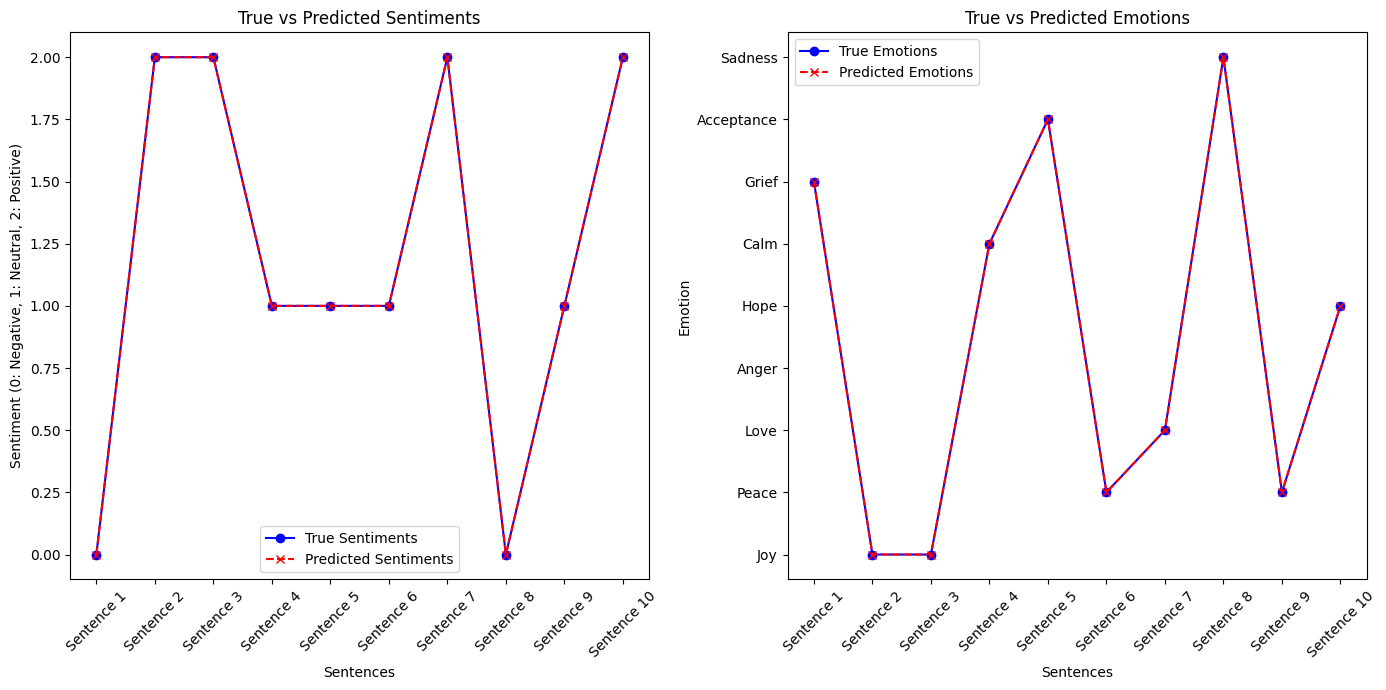

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.utils.data import DataLoader, TensorDataset

# Load fine-tuned models
sentiment_model = AutoModelForSequenceClassification.from_pretrained('./fine_tuned_sentiment_model')
emotion_model = AutoModelForSequenceClassification.from_pretrained('./fine_tuned_emotion_model')

# Load tokenizers
sentiment_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
emotion_tokenizer = AutoTokenizer.from_pretrained("bhadresh-savani/distilbert-base-uncased-emotion")

# Move models to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sentiment_model.to(device)
emotion_model.to(device)

# Select a subset of the dataset (e.g., 10 random samples)
subset_size = 10
subset_data = poetry_data_balanced.sample(n=subset_size, random_state=42)

# True sentiment and emotion labels
true_sentiments = subset_data['Sentiment'].tolist()
true_emotions = subset_data['Emotion'].tolist()

# Convert true labels to numerical format (based on the mappings)
sentiment_label_mapping = {
    'Negative': 0,
    'Neutral': 1,
    'Positive': 2
}

emotion_label_mapping = {
    'Joy': 0,
    'Peace': 1,
    'Love': 2,
    'Anger': 3,
    'Hope': 4,
    'Calm': 5,
    'Grief': 6,
    'Acceptance': 7,
    'Sadness': 8,
}

true_sentiments_numerical = [sentiment_label_mapping[s] for s in true_sentiments]
true_emotions_numerical = [emotion_label_mapping[e] for e in true_emotions]

# Tokenize the sentences
sentiment_inputs = sentiment_tokenizer(subset_data['Sentence'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)
emotion_inputs = emotion_tokenizer(subset_data['Sentence'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)

# Get predicted values for sentiment
with torch.no_grad():
    sentiment_outputs = sentiment_model(**sentiment_inputs)
    sentiment_predictions = sentiment_outputs.logits.argmax(dim=-1).cpu().numpy()

# Get predicted values for emotion
with torch.no_grad():
    emotion_outputs = emotion_model(**emotion_inputs)
    emotion_predictions = emotion_outputs.logits.argmax(dim=-1).cpu().numpy()

# Plot line graph comparing true vs. predicted values for both sentiment and emotion

# Set up categories for labels
categories = [f"Sentence {i+1}" for i in range(len(subset_data))]

# Create the emotion label mapping for the y-axis
emotion_names = ['Joy', 'Peace', 'Love', 'Anger', 'Hope', 'Calm', 'Grief', 'Acceptance', 'Sadness']

plt.figure(figsize=(14, 7))

# Line graph for sentiment
plt.subplot(1, 2, 1)
plt.plot(categories, true_sentiments_numerical, marker='o', color='blue', label='True Sentiments')
plt.plot(categories, sentiment_predictions, marker='x', color='red', linestyle='--', label='Predicted Sentiments')
plt.xlabel('Sentences')
plt.ylabel('Sentiment (0: Negative, 1: Neutral, 2: Positive)')
plt.title('True vs Predicted Sentiments')
plt.xticks(rotation=45)
plt.legend()

# Line graph for emotion with emotion names on the y-axis
plt.subplot(1, 2, 2)
plt.plot(categories, true_emotions_numerical, marker='o', color='blue', label='True Emotions')
plt.plot(categories, emotion_predictions, marker='x', color='red', linestyle='--', label='Predicted Emotions')
plt.xlabel('Sentences')
plt.ylabel('Emotion')
plt.yticks(ticks=np.arange(len(emotion_names)), labels=emotion_names)  # Show emotion names on the y-axis
plt.title('True vs Predicted Emotions')
plt.xticks(rotation=45)
plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [15]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load fine-tuned models
sentiment_model = AutoModelForSequenceClassification.from_pretrained('./fine_tuned_sentiment_model')
emotion_model = AutoModelForSequenceClassification.from_pretrained('./fine_tuned_emotion_model')

# Load tokenizers
sentiment_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
emotion_tokenizer = AutoTokenizer.from_pretrained("bhadresh-savani/distilbert-base-uncased-emotion")

# Move models to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sentiment_model.to(device)
emotion_model.to(device)

# Custom Marathi sentences (replace with your own)
marathi_sentences = ["In your laughter, I find my heart’s melody dancing through every shared moment",
"Like sunbeams breaking clouds, your smile ignites warmth, filling the air with light",
"Lost in echoes of absence I wander shadows where fading memories linger dimly",
"Each tear falls like raindrops on earth nurturing wounds of aching hearts",
"In quiet dawn I breathe deeply, embracing life’s ebb letting go completely"
]

# English translations of the above sentences
english_translations = [" ",
" ",
" ",
" ",
" "
]

# Tokenize the Marathi sentences
sentiment_inputs = sentiment_tokenizer(marathi_sentences, padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)
emotion_inputs = emotion_tokenizer(marathi_sentences, padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)

# Get predicted values for sentiment
with torch.no_grad():
    sentiment_outputs = sentiment_model(**sentiment_inputs)
    sentiment_predictions = sentiment_outputs.logits.argmax(dim=-1).cpu().numpy()

# Get predicted values for emotion
with torch.no_grad():
    emotion_outputs = emotion_model(**emotion_inputs)
    emotion_predictions = emotion_outputs.logits.argmax(dim=-1).cpu().numpy()

# Sentiment and emotion mappings
sentiment_label_mapping = {
    0: 'Negative',
    1: 'Neutral',
    2: 'Positive'
}

emotion_label_mapping = {
    0: 'Joy',
    1: 'Peace',
    2: 'Love',
    3: 'Anger',
    4: 'Hope',
    5: 'Calm',
    6: 'Grief',
    7: 'Acceptance',
    8: 'Sadness'
}

# Display Marathi sentence, predicted sentiment, emotion, and their English translation
for i, sentence in enumerate(marathi_sentences):
    predicted_sentiment = sentiment_label_mapping[sentiment_predictions[i]]
    predicted_emotion = emotion_label_mapping[emotion_predictions[i]]
    english_translation = english_translations[i]

    print(f"Marathi Sentence: {sentence}")
    print(f"English Translation: {english_translation}")
    print(f"Predicted Sentiment: {predicted_sentiment}")
    print(f"Predicted Emotion: {predicted_emotion}")
    print("-" * 50)


Marathi Sentence: In your laughter, I find my heart’s melody dancing through every shared moment
English Translation:  
Predicted Sentiment: Positive
Predicted Emotion: Joy
--------------------------------------------------
Marathi Sentence: Like sunbeams breaking clouds, your smile ignites warmth, filling the air with light
English Translation:  
Predicted Sentiment: Positive
Predicted Emotion: Joy
--------------------------------------------------
Marathi Sentence: Lost in echoes of absence I wander shadows where fading memories linger dimly
English Translation:  
Predicted Sentiment: Negative
Predicted Emotion: Grief
--------------------------------------------------
Marathi Sentence: Each tear falls like raindrops on earth nurturing wounds of aching hearts
English Translation:  
Predicted Sentiment: Negative
Predicted Emotion: Grief
--------------------------------------------------
Marathi Sentence: In quiet dawn I breathe deeply, embracing life’s ebb letting go completely
English